original_cols, original_rows: 5551 3123
infer_cols, infer_rows: 1919 1080
finish infer in 1.697241780999775 seconds


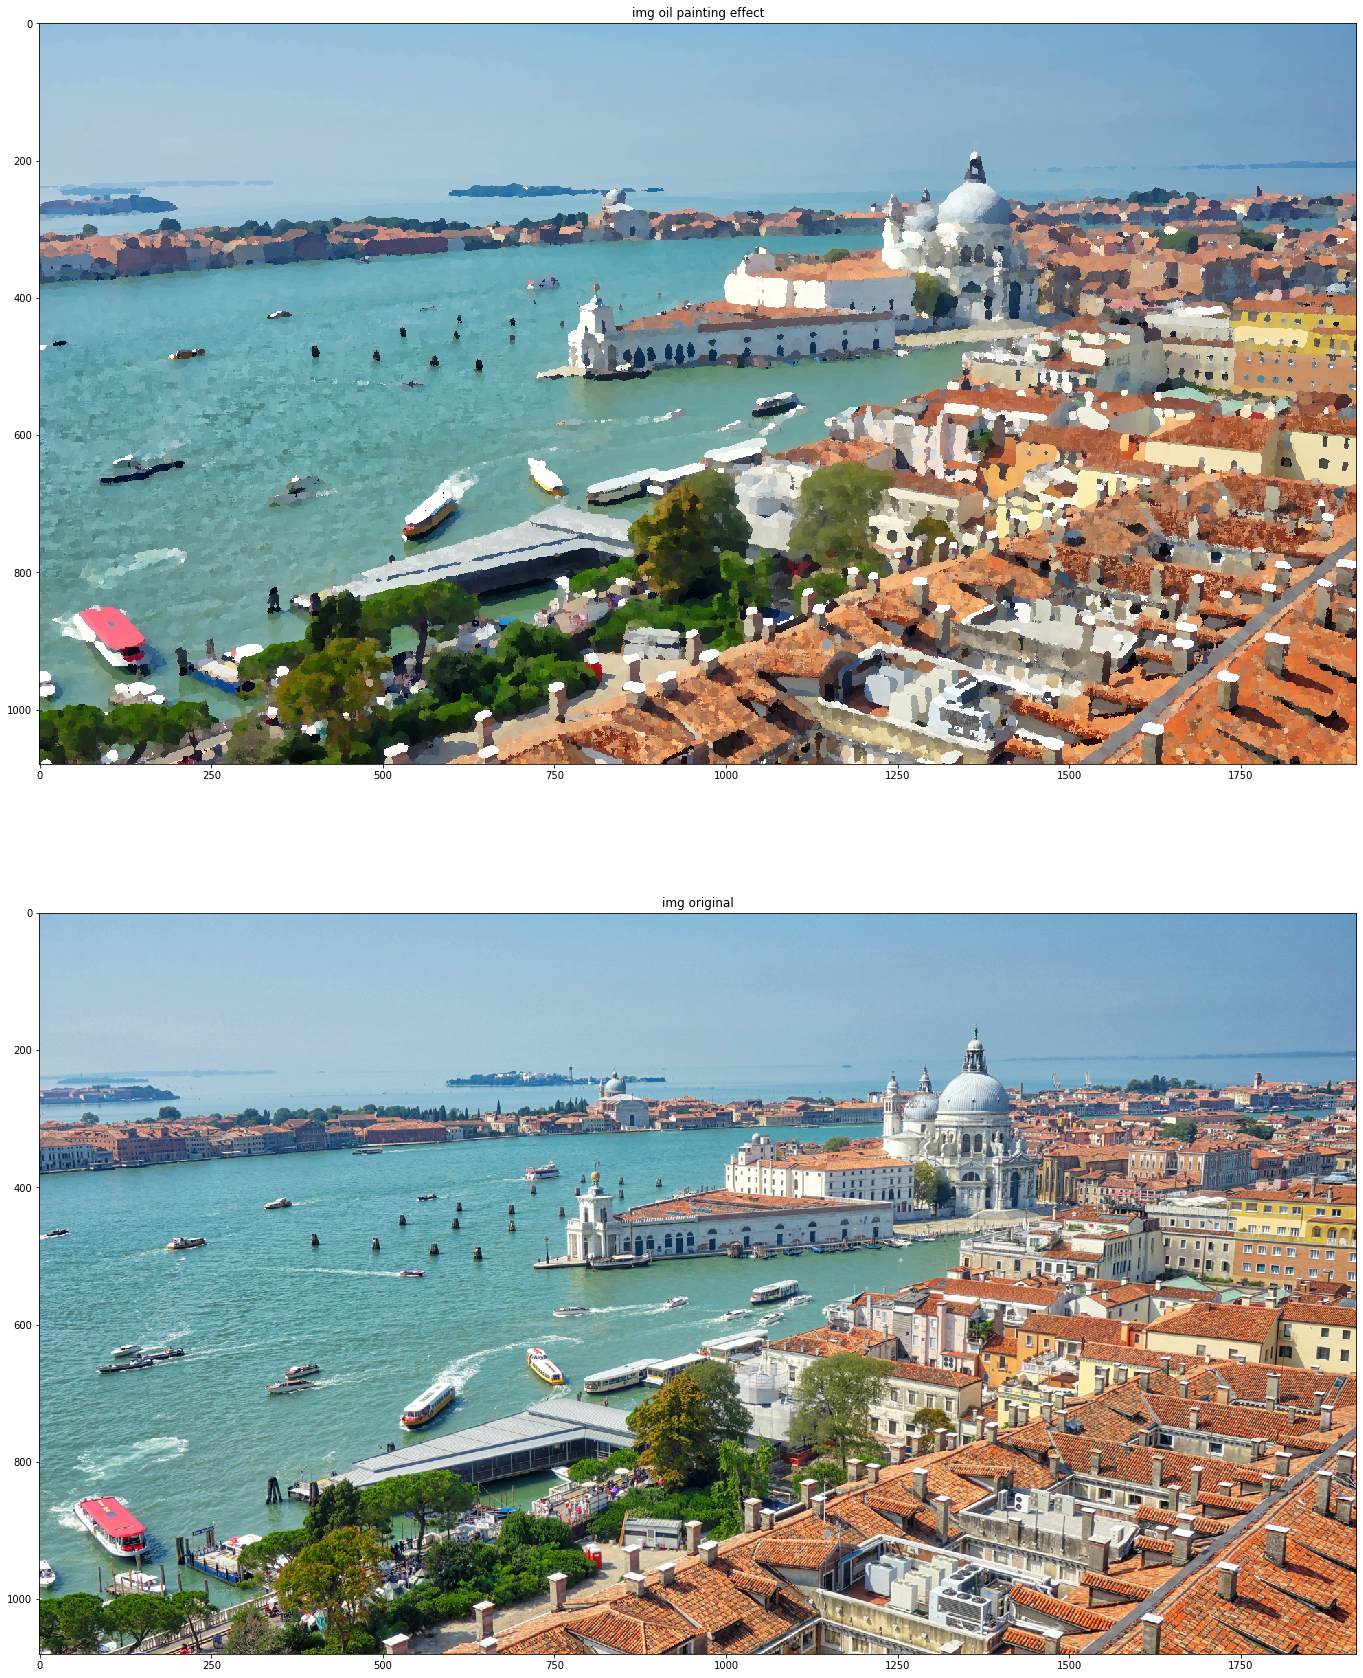

In [1]:
import numpy as np
from numba import cuda
import copy
from PIL import Image
import time


@cuda.jit
def oil_painting_algo_cuda(img_from, img_to,
                           intensity_count, average_rgb,
                           num_bins, kernel_size):
    # http://supercomputingblog.com/graphics/oil-painting-algorithm/
    i, j = cuda.grid(2)
    if i >= img_from.shape[0] or j >= img_from.shape[1]:
        return

    top = max(i - kernel_size, 0)
    bot = min(i + kernel_size, img_from.shape[0])
    left = max(j - kernel_size, 0)
    right = min(j + kernel_size, img_from.shape[1])

    for x in range(top, bot):
        for y in range(left, right):
            cur_r = img_from[x, y, 0]
            cur_g = img_from[x, y, 1]
            cur_b = img_from[x, y, 2]
            cur_intensity = int(float(cur_r + cur_g + cur_b) / 3. / 255. * num_bins)
            intensity_count[i, j, cur_intensity] += 1
            average_rgb[i, j, cur_intensity, 0] += cur_r
            average_rgb[i, j, cur_intensity, 1] += cur_g
            average_rgb[i, j, cur_intensity, 2] += cur_b

    cur_max = 0
    max_index = 0
    for cur_intensity in range(num_bins + 1):
        if intensity_count[i, j, cur_intensity] > cur_max:
            cur_max = intensity_count[i, j, cur_intensity]
            max_index = cur_intensity

    img_to[i, j, 0] = average_rgb[i, j, max_index, 0] / cur_max
    img_to[i, j, 1] = average_rgb[i, j, max_index, 1] / cur_max
    img_to[i, j, 2] = average_rgb[i, j, max_index, 2] / cur_max


def oil_painting_algo_launch(img_np: np.ndarray, num_bins=20, kernel_size=6) -> np.ndarray:
    img_from = img_np.astype(int)
    img_to = copy.deepcopy(img_from)
    rows, cols, channels = img_from.shape
    intensity_count = np.zeros([rows, cols, num_bins], dtype=int)
    average_rgb = np.zeros([rows, cols, num_bins, 3], dtype=int)

    d_img_from = cuda.to_device(img_from)
    d_img_to = cuda.to_device(img_to)
    d_intensity_count = cuda.to_device(intensity_count)
    d_average_rgb = cuda.to_device(average_rgb)
    block_size = (16, 16)
    grid_size = (int((rows + 16 - 1) / 16), int((cols + 16 - 1) / 16))
    oil_painting_algo_cuda[grid_size, block_size](d_img_from, d_img_to,
                                                  d_intensity_count, d_average_rgb,
                                                  num_bins, kernel_size)
    img_to = d_img_to.copy_to_host().astype(np.uint8)
    return img_to


def test():
    img_path = "./Venice.jpg"
    num_bins = 50
    kernel_size = 5

    img = Image.open(img_path)
    start_time = time.perf_counter()
    original_cols, original_rows = img.size
    scale_fac = np.sqrt((1920 * 1080) / (original_cols * original_rows))
    infer_cols, infer_rows = int(original_cols * scale_fac), int(original_rows * scale_fac)
    print("original_cols, original_rows:", original_cols, original_rows)
    print("infer_cols, infer_rows:", infer_cols, infer_rows)
    img = img.resize((infer_cols, infer_rows))
    img_np = np.asarray(img)
    img_oil_np = oil_painting_algo_launch(img_np, num_bins=num_bins, kernel_size=kernel_size)
    img_oil = Image.fromarray(img_oil_np, mode="RGB")
    end_time = time.perf_counter()
    print(f"finish infer in {end_time - start_time} seconds")
    img.save("cache_1.jpg")
    img_oil.save("cache_2.jpg")

    import matplotlib.pyplot as plt
    fig1 = plt.figure(figsize=(30, 30))  # create a figure with the default size

    ax1 = fig1.add_subplot(2, 1, 1)
    ax1.imshow(img_oil, interpolation='none')
    ax1.set_title('img oil painting effect')

    ax2 = fig1.add_subplot(2, 1, 2)
    ax2.imshow(img, interpolation='none')
    ax2.set_title('img original')

    plt.show()


if __name__ == '__main__':
    test()


In [2]:
!nvidia-smi

Sun Mar 20 03:59:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.52       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0    22W /  N/A |    830MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Fri_Dec_17_18:16:03_PST_2021
Cuda compilation tools, release 11.6, V11.6.55
Build cuda_11.6.r11.6/compiler.30794723_0
